In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
import numpy as np
import cv2
import os
from PIL import Image

### Idea: 
* Reconstruction based anomaly detection (= solved as an inverse problem)
    
### Data model = forward and inverse modeling:
Given the forward modeling (FWM) of the problem  
     $$y = f(x),$$
where  
 * $y$: observed data, based on a consistent pattern but possibly with anomalies
 * $x$: unknown underlying structure, WITHOUT anomalies (e.g. y without anomalies) 
 * $f$: mapping from $x$ to $y$.  
We seek to estimate the unknown, most-likely pattern of the observation by solving
    $$\hat{x} = g(y),$$
where
* $\hat{x}$: an estimate of $x$
* $g$: inverse mapping <- which is modeled as an autoencoder here

### Anomaly detection:
This method "detects" anomalies by comparing the "error" = $y - \hat{x}$.    
With that said, if the "error" is high, we presume that there likely be anomalies in $y$. 

### Why this approach?
* We have a limited number of data with anomalies
* Our data include a consistent geometric pattern with strong contrast
    => presumably, the underlying pattern (i.e. $x$) is quite easy to construct / estimate from the data ($y$) 
* Anomalies in our data tend to have much weaker contrast than to the underlying pattern  
  => (??) possibly the "error" may not be large enough 

### Open questions:
* Currently using MSE, but is it really a good metric? May not be suitable for low-contrast anomalies? 


In [2]:
# Encoder = pre-trained ResNet-18 model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet18 = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2])  # Remove FC layer
    
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # US by 2
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # US by 2
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # US by 2
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # US by 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), # US by 2
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x)

# Combine encoder and decoder into an autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

# Training to estimate "normal" images
class Training():
    def __init__(self):
        # Instantiate the autoencoder: note, Mac does not support CUDA
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Autoencoder().to(self.device)
        
    def get_model(self):
        return self.model

    @property
    def transformer(self):
        return self._transform
    @transformer.setter
    def transformer(self, _transformer):
        self._transform = _transformer

    @property
    def optimizer(self):
        return self._optimizer   
    @optimizer.setter
    def optimizer(self, _lr):
        # parameter: _lr = learning rate
        # Instantiate the optimizer --> currently using Adam (with no particular reasons though...)
        self._optimizer = torch.optim.Adam(self.model.decoder.parameters(), lr=_lr)

    @property
    def metric(self):
        return self._metric
    @metric.setter
    def metric(self, _metric):
        self._metric = _metric

    def train(self, train_folder, num_epochs=10):
        # Remove hidden files that Mac OS automatically creates (e.g. ._001.png)
        image_files = sorted([f for f in os.listdir(train_folder) if not f.startswith("._") and not f.startswith(".")])
        
        self.model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for img_name in image_files:
                # Load <-- as numpy array
                img_path = os.path.join(train_folder, img_name)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Convert to PIL Image <-- compatible with torch vision
                image = Image.fromarray(image)
                image = self.transformer(image).unsqueeze(0).to(self.device)  # Add batch dimension
                # Fit
                self.optimizer.zero_grad() # reset
                reco = self.model(image)
                loss = self.metric(reco, image)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

## Training + Test

In [14]:
# Define transformations 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

In [15]:
# Training
path_train = "/Volumes/Sandisk_SD/Work/ML_dataset/mvtec_anomaly_detection/screw/train/good"

training = Training()
training.transformer = transform
training.optimizer = 10**-3 # learning rate
training.metric = nn.L1Loss()
training.train(train_folder=path_train, num_epochs=10)
model = training.get_model()

Epoch 1, Loss: 27.5519
Epoch 2, Loss: 21.7400
Epoch 3, Loss: 21.1265
Epoch 4, Loss: 19.9886
Epoch 5, Loss: 19.2211
Epoch 6, Loss: 18.7451
Epoch 7, Loss: 18.3155
Epoch 8, Loss: 18.0492
Epoch 9, Loss: 17.9651
Epoch 10, Loss: 17.9342


In [16]:
# Anomaly detection
class Test():
    def __init__(self):
        pass

    @property
    def model(self):
        return self._model
    @model.setter
    def model(self, _model):
        self._model = _model

    @property
    def transformer(self):
        return self._transformer
    @transformer.setter
    def transformer(self, _transformer):
        self._transformer = _transformer 

    def reconstruction(self, img_path, ret_numpy=False):
        # Load <-- as numpy array
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert to PIL Image <-- compatible with torch vision
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = Image.fromarray(image)
        image = self.transformer(image).unsqueeze(0).to(device)  # Add batch dimension
    
        self.model.eval()
        with torch.no_grad():
            reco = self.model(image)
        if ret_numpy == False:
            return image, reco
        else:
            return image.numpy(), reco.numpy()
    
    def anomaly_score(self, img_path):
        image, reco = self.reconstruction(img_path)
        score = torch.nn.functional.mse_loss(reco, image).item()
        return score

    def run_multiple_tests(self, test_folder, ret_file_names=False):
        # Remove hidden files that Mac OS automatically creates (e.g. ._001.png)
        image_files = sorted([f for f in os.listdir(test_folder) if not f.startswith("._") and not f.startswith(".")])
        # Base
        results = []
        for img_name in image_files:
            img_path = os.path.join(test_folder, img_name)
            results.append(self.anomaly_score(img_path))

        if ret_file_names == False:
            return np.array(results)
        else:
            info = {
                'files': image_files,
                'results': np.array(results)
            }
            return info

In [17]:
# Test
path_test_rel = "/Volumes/Sandisk_SD/Work/ML_dataset/mvtec_anomaly_detection/screw/test"
path_test_good = f'{path_test_rel}/good' # total images = 40
path_test_bad = [
    "manipulated_front", # 23
    "scratch_head", #23
    "scratch_neck", #24
    "thread_side", #22
    "thread_top" #22
]

testing = Test()
testing.model = model
testing.transformer = transform
pred_good = testing.run_multiple_tests(path_test_good)

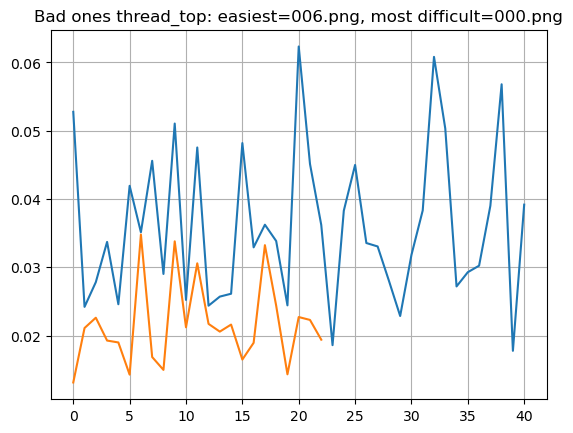

In [18]:
idx_bad = -1
pred_bad = testing.run_multiple_tests(os.path.join(path_test_rel, path_test_bad[idx_bad]))

import matplotlib.pyplot as plt
plt.plot(pred_good)
plt.plot(pred_bad)
plt.title(f'Bad ones {path_test_bad[idx_bad]}: easiest={str(int(np.argmax(pred_bad))).zfill(3)}.png, most difficult={str(int(np.argmin(pred_bad))).zfill(3)}.png')
plt.grid(True)
plt.show()

In [19]:
img_hardest, reco_hardest = testing.reconstruction(
    img_path=os.path.join(path_test_rel, path_test_bad[idx_bad], f'{str(int(np.argmin(pred_bad))).zfill(3)}.png'),
    ret_numpy=True
)
img_easiest, reco_easiest = testing.reconstruction(
    img_path=os.path.join(path_test_rel, path_test_bad[idx_bad], f'{str(int(np.argmax(pred_bad))).zfill(3)}.png'),
    ret_numpy=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.6784314].


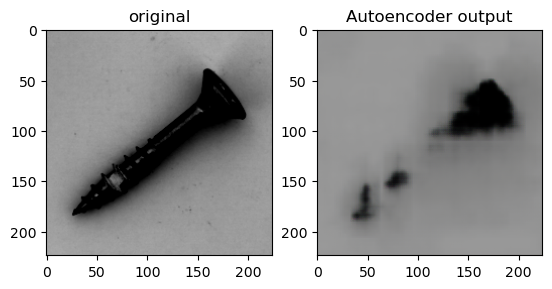

In [23]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
# Top row: easiest, left=original, right=reco
axs[0].imshow(np.rollaxis(img_easiest[0, ...], axis=0, start=3))
axs[0].set_title('original')
axs[1].imshow(np.rollaxis(reco_easiest[0, ...], axis=0, start=3))
axs[1].set_title('Autoencoder output')
# Bottom row: most difficult, left=original, right=reco
# axs[1, 0].imshow(np.rollaxis(img_hardest[0, ...], axis=0, start=3))
# axs[1, 1].imshow(np.rollaxis(reco_hardest[0, ...], axis=0, start=3))
plt.show()

In [ ]:
# Histograms
# Original, but transformed image
counts_orig, bins_orig = np.histogram(img_easiest, bins=10)
counts_reco, bins_reco = np.histogram(reco_easiest, bins=10)

fig, axs = plt.subplots(1, 2)
axs[0].stairs(counts_orig, bins_orig)
axs[0].set_title('Original')
axs[1].stairs(counts_reco, bins_reco)
axs[1].set_title('Reco')

In [ ]:
plt.plot(reco_hardest[0, 2, ...].flatten('F'))

In [ ]:
plt.close('all')